# Работа с моделью

Импорт библиотек

In [17]:
import numpy as np
from catboost import CatBoostRegressor
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt

Загрузка данных

In [18]:
# Загрузка данных
train_df = pd.read_excel("data/excel/train.xlsx")
test_df = pd.read_excel("data/excel/test.xlsx")

Преобразование dt в datetime для удобного использования в Pandas

In [19]:
train_df['dt'] = pd.to_datetime(train_df['dt'], dayfirst=True)
test_df['dt'] = pd.to_datetime(test_df['dt'], dayfirst=True)

Переименовываем колонку с ценой

In [20]:
train_df.rename(columns={'Цена на арматуру': 'Price'}, inplace=True, errors='ignore')
test_df.rename(columns={'Цена на арматуру': 'Price'}, inplace=True, errors='ignore')

Объединение данных и установка индекса на колонку  `dt`

In [21]:
combined_df = pd.concat([train_df[['dt', 'Price']], test_df[['dt', 'Price']]]).reset_index(drop=True)
combined_df = combined_df.set_index('dt')
combined_df.to_excel('combined_df.xlsx', index=True)

Формирую признаки `(X)` и целевую переменную `(y)` для обучения модели

In [22]:
X = combined_df.drop(columns=['Price']).iloc[:-1, :]
y = combined_df['Price'].values[1:]
X['Price_source'] = combined_df['Price'].values[:-1]
y = y[1:]
X = X.iloc[1:, :]

Разделение данных для обучения модели

In [23]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

Логарифмирование целевой переменной

In [24]:
y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test)

Кросс-валидация

In [25]:
tscv = TimeSeriesSplit(n_splits=3)

Подбор гиперпараметров

In [26]:
param_grid = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.02, 0.05],
    'depth': [4, 5, 6],
    'l2_leaf_reg': [1, 3, 5],
    'early_stopping_rounds': [50, 100]
}

catboost = CatBoostRegressor(loss_function='MAE', has_time=True, verbose=0)

grid_search = GridSearchCV(catboost, param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train_log)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001AB64156A80>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6], 'early_stopping_rounds': [50, 100],
                         'iterations': [500, 1000, 1500],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.01, 0.02, 0.05]},
             scoring='neg_mean_absolute_error')

Лучшие параметры для модели

In [27]:
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

Лучшие параметры: {'depth': 4, 'early_stopping_rounds': 50, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.02}


Обучение модели с лучшими параметрами

In [28]:
model = CatBoostRegressor(**best_params, loss_function='MAE', has_time=True)
model.fit(X_train, y_train_log, eval_set=(X_test, y_test_log))

0:	learn: 0.1818516	test: 0.4581196	best: 0.4581196 (0)	total: 543us	remaining: 271ms
1:	learn: 0.1786210	test: 0.4503552	best: 0.4503552 (1)	total: 895us	remaining: 223ms
2:	learn: 0.1759264	test: 0.4427113	best: 0.4427113 (2)	total: 1.22ms	remaining: 201ms
3:	learn: 0.1728553	test: 0.4344062	best: 0.4344062 (3)	total: 1.52ms	remaining: 188ms
4:	learn: 0.1696944	test: 0.4262113	best: 0.4262113 (4)	total: 1.79ms	remaining: 177ms
5:	learn: 0.1671339	test: 0.4206459	best: 0.4206459 (5)	total: 2.08ms	remaining: 171ms
6:	learn: 0.1639390	test: 0.4134105	best: 0.4134105 (6)	total: 2.35ms	remaining: 166ms
7:	learn: 0.1618338	test: 0.4101489	best: 0.4101489 (7)	total: 2.69ms	remaining: 165ms
8:	learn: 0.1596101	test: 0.4041676	best: 0.4041676 (8)	total: 2.95ms	remaining: 161ms
9:	learn: 0.1571462	test: 0.4015274	best: 0.4015274 (9)	total: 3.2ms	remaining: 157ms
10:	learn: 0.1547951	test: 0.3983983	best: 0.3983983 (10)	total: 3.47ms	remaining: 154ms
11:	learn: 0.1517845	test: 0.3900933	best: 0

Оценка модели

In [29]:
mae_scores = cross_val_score(model, X_train, y_train_log, cv=tscv, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(model, X_train, y_train_log, cv=tscv, scoring='r2')

0:	learn: 0.1399757	total: 374us	remaining: 187ms
1:	learn: 0.1376622	total: 800us	remaining: 199ms
2:	learn: 0.1354173	total: 1.03ms	remaining: 170ms
3:	learn: 0.1331035	total: 1.18ms	remaining: 147ms
4:	learn: 0.1310020	total: 1.33ms	remaining: 132ms
5:	learn: 0.1288923	total: 1.62ms	remaining: 133ms
6:	learn: 0.1267259	total: 1.8ms	remaining: 127ms
7:	learn: 0.1242981	total: 2.35ms	remaining: 145ms
8:	learn: 0.1222137	total: 2.66ms	remaining: 145ms
9:	learn: 0.1202129	total: 2.9ms	remaining: 142ms
10:	learn: 0.1179374	total: 3.07ms	remaining: 136ms
11:	learn: 0.1160952	total: 3.28ms	remaining: 134ms
12:	learn: 0.1138687	total: 3.45ms	remaining: 129ms
13:	learn: 0.1119422	total: 3.61ms	remaining: 125ms
14:	learn: 0.1103623	total: 3.8ms	remaining: 123ms
15:	learn: 0.1083026	total: 4.01ms	remaining: 121ms
16:	learn: 0.1062881	total: 4.16ms	remaining: 118ms
17:	learn: 0.1045991	total: 4.41ms	remaining: 118ms
18:	learn: 0.1029747	total: 4.57ms	remaining: 116ms
19:	learn: 0.1009869	total:

Предсказание и оценка модели по всем метрикам

In [30]:
preds = np.expm1(model.predict(X_test))

# Метрики
print(f"R²: {r2_score(y_test, preds):.4f}")
print(f"MAE: {mean_absolute_error(y_test, preds):.4f}")
print(f"MSE: {mean_squared_error(y_test, preds):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.4f}")
print(f"Средний MAE на кросс-валидации: {-mae_scores.mean():.4f}")
print(f"Средний R² на кросс-валидации: {r2_scores.mean():.4f}")

R²: 0.9329
MAE: 2219.5498
MSE: 8790788.8757
RMSE: 2964.9265
Средний MAE на кросс-валидации: 0.0518
Средний R² на кросс-валидации: 0.7669


Визуализация результатов обучения модели

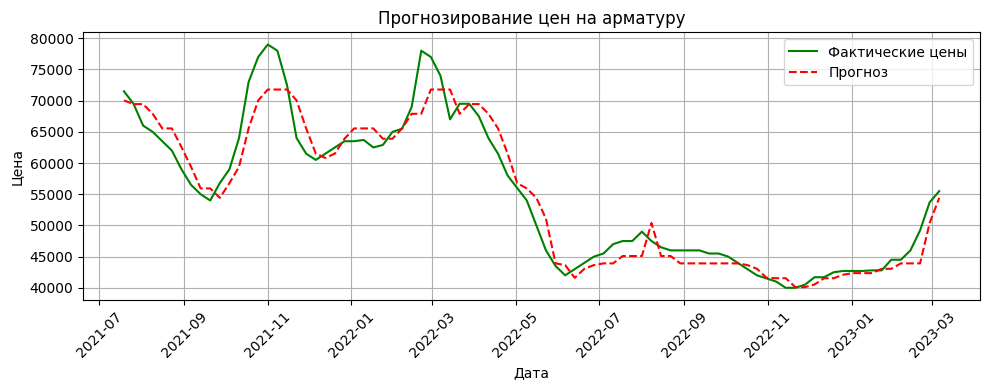

In [31]:
# Визуализация
plt.figure(figsize=(10, 4))
plt.plot(X_test.index, y_test, label='Фактические цены', color='green')
plt.plot(X_test.index, preds, label='Прогноз', color='red', linestyle='--')
plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Сохранение модели

In [32]:
model.save_model("main_model.cbm")